In [1]:
# Import required packages
import pandas as pd
from pyspark.sql import SparkSession

In [2]:
# Read Data
data_filepath = '/home/shinde/Documents/Personal/Applications/Flightright/Flightright Coding Challenge/Flightright Coding Challenge/2. Prediction Model/dataframe.csv'
spark = SparkSession.builder.appName('ml_flight').getOrCreate()
df = spark.read.csv(data_filepath, header = True, inferSchema = True)
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- month_interaction_count: integer (nullable = true)
 |-- week_interaction_count: integer (nullable = true)
 |-- day_interaction_count: integer (nullable = true)
 |-- cancelled_within_week: integer (nullable = true)



In [3]:
# Read data as dataframe
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
user_id,66860ae6,249803f8,32ed74cc,7ed76e6a,46c81f43
month_interaction_count,41,25,21,22,32
week_interaction_count,9,9,2,5,8
day_interaction_count,0,2,1,2,2
cancelled_within_week,1,0,1,0,0


In [4]:
# Display numeric values as a dataframe
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
month_interaction_count,10,30.0,6.5149400952306875,21,41
week_interaction_count,10,7.0,2.9059326290271157,2,11
day_interaction_count,10,1.0,0.816496580927726,0,2
cancelled_within_week,10,0.5,0.5270462766947299,0,1


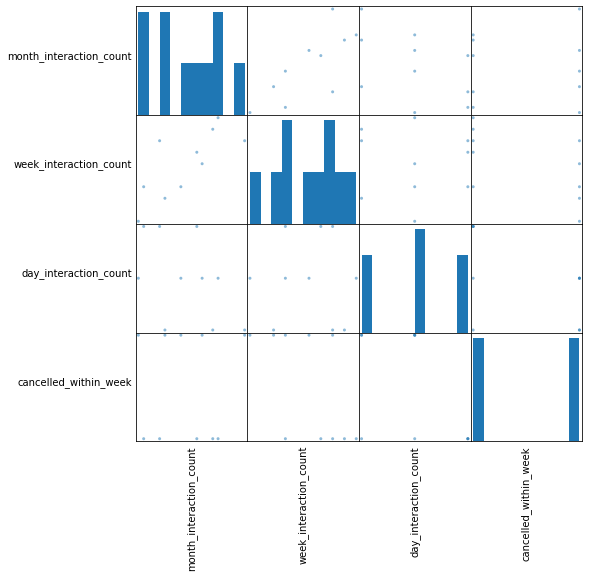

In [5]:
# Correlation between independent variables
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [6]:
# Category indexing and vector assembly
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
#from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['user_id']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'cancelled_within_week', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['month_interaction_count', 'week_interaction_count', 'day_interaction_count']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [7]:
cols = df.columns

In [8]:
# Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label','features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- user_id: string (nullable = true)
 |-- month_interaction_count: integer (nullable = true)
 |-- week_interaction_count: integer (nullable = true)
 |-- day_interaction_count: integer (nullable = true)
 |-- cancelled_within_week: integer (nullable = true)



In [9]:
# Defining the training and testing datasets
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 8
Test Dataset Count: 2


In [10]:
# Fit logistic regression model 
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, threshold = 0.6, elasticNetParam=0.8, regParam=0.1)
lrModel = lr.fit(train)

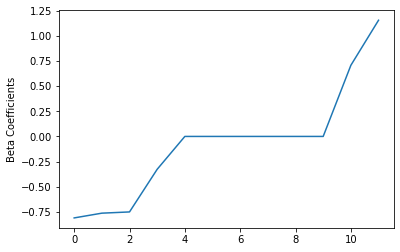

In [11]:
# Plotting beta cooefficients
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/home/shinde/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


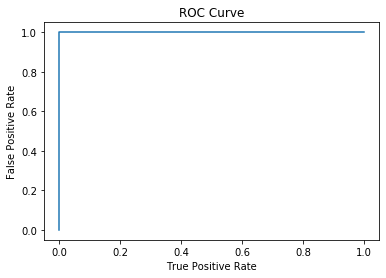

Training set areaUnderROC: 1.0


In [12]:
#Plotting the ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

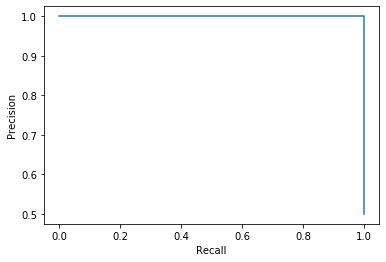

In [13]:
# Plotting precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [14]:
# Printing the predictions for each user_id in the test dataset
predictions = lrModel.transform(test)
predictions.select('user_id','rawPrediction', 'prediction', 'probability').show(10)

+--------+--------------------+----------+--------------------+
| user_id|       rawPrediction|prediction|         probability|
+--------+--------------------+----------+--------------------+
|249803f8|[1.69050513070991...|       0.0|[0.84429057792833...|
|86a060ec|[0.22418988298323...|       0.0|[0.55581389401341...|
+--------+--------------------+----------+--------------------+

